In [22]:
import gzip
import pandas as pd

file_path = 'Data/amazon_meta.json'  
df_meta = pd.read_json(file_path, lines=True, compression=None)

In [23]:
df_meta.columns

Index(['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2',
       'brand', 'feature', 'rank', 'also_view', 'main_cat', 'similar_item',
       'date', 'price', 'asin', 'imageURL', 'imageURLHighRes', 'details'],
      dtype='object')

In [24]:
df_meta.shape

(633883, 19)

In [25]:
df_meta['asin'].unique().shape

(624284,)

In [26]:
df_meta.isna().sum()

category              0
tech1                 0
description           0
fit                   0
title                 0
also_buy              0
tech2                 0
brand                 0
feature               0
rank                  0
also_view             0
main_cat              0
similar_item          0
date                  0
price                 0
asin                  0
imageURL              0
imageURLHighRes       0
details            1462
dtype: int64

#### Drop Duplicates

In [27]:
df_meta = df_meta.drop_duplicates(subset=['asin'])

## Incidents Data

In [28]:
df_arts = pd.read_csv('Data/Toysandchildren_ArtsandCrafts.csv', skiprows=2)
df_riding = pd.read_csv('Data/Toysandchildren_Riding_Toys.csv', skiprows=1)
df_toys = pd.read_csv('Data/Toysandchildren_Toys.csv', skiprows=1)

In [29]:
reports = pd.concat([df_arts, df_riding, df_toys], ignore_index=True)

In [30]:
# save combined dataframe
reports.to_csv("combined_toys.csv", index=False)

In [ ]:
# reports = pd.read_csv("combined_toys.csv")

In [31]:
reports.shape

(2514, 40)

In [32]:
reports.columns

Index(['Report No.', 'Report Date',
       'Sent to Manufacturer / Importer / Private Labeler', 'Publication Date',
       'Category of Submitter', 'Product Description', 'Product Category',
       'Product Sub Category', 'Product Type', 'Product Code',
       'Manufacturer / Importer / Private Labeler Name', 'Brand',
       'Model Name or Number', 'Serial Number', 'UPC', 'Date Manufactured',
       'Manufacturer Date Code', 'Retailer', 'Retailer State', 'Purchase Date',
       'Purchase Date Is Estimate', 'Incident Description', 'City', 'State',
       'ZIP', 'Location', '(Primary) Victim Severity',
       '(Primary) Victim's Sex', 'My Relation To The (Primary) Victim',
       '(Primary) Victim's Age (years)', 'Submitter Has Product',
       'Product Was Damaged Before Incident', 'Damage Description',
       'Damage Repaired', 'Product Was Modified Before Incident',
       'Have You Contacted The Manufacturer', 'If Not Do You Plan To',
       'Answer Explanation', 'Company Comments', 

In [33]:
reports.isna().sum()

Report No.                                              0
Report Date                                             0
Sent to Manufacturer / Importer / Private Labeler     176
Publication Date                                        0
Category of Submitter                                   0
Product Description                                     0
Product Category                                        0
Product Sub Category                                    0
Product Type                                            0
Product Code                                            0
Manufacturer / Importer / Private Labeler Name          2
Brand                                                 148
Model Name or Number                                  770
Serial Number                                        1831
UPC                                                  1740
Date Manufactured                                    2204
Manufacturer Date Code                               2150
Retailer      

In [34]:
reports['Date Manufactured'].isna().sum()

2204

In [35]:
# Filter to reports of items manufactured before October 2018, and include if the manufactured date is null.
# since items manufuctered after this data won't appear in the amazon dataset
reports['Date Manufactured']=pd.to_datetime(reports['Date Manufactured'].astype(str).str.strip(), errors='coerce')
reports=reports[(reports['Date Manufactured']<='Oct 2018') | (reports['Date Manufactured'].isna())]

In [36]:
reports.shape

(2363, 40)

In [143]:
# Features we can use for fuzzy matching.
print(df_meta.columns)
print(reports.columns)

Index(['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2',
       'brand', 'feature', 'rank', 'also_view', 'main_cat', 'similar_item',
       'date', 'price', 'asin', 'imageURL', 'imageURLHighRes', 'details'],
      dtype='object')
Index(['Report No.', 'Report Date',
       'Sent to Manufacturer / Importer / Private Labeler', 'Publication Date',
       'Category of Submitter', 'Product Description', 'Product Category',
       'Product Sub Category', 'Product Type', 'Product Code',
       'Manufacturer / Importer / Private Labeler Name', 'Brand',
       'Model Name or Number', 'Serial Number', 'UPC', 'Date Manufactured',
       'Manufacturer Date Code', 'Retailer', 'Retailer State', 'Purchase Date',
       'Purchase Date Is Estimate', 'Incident Description', 'City', 'State',
       'ZIP', 'Location', '(Primary) Victim Severity',
       '(Primary) Victim's Sex', 'My Relation To The (Primary) Victim',
       '(Primary) Victim's Age (years)', 'Submitter Has Product',
 

### 🔍 Note

The following approach matches **only one Amazon product per incident report** — specifically, the one with the **highest similarity score**. While this is useful for initial analysis and exploration, it does not fully align with our objective.

Our goal is to identify **all Amazon products** that exhibit **high similarity** to each incident report, not just the single best match.

To achieve this, we will adopt a **matrix-based approach**. In this setup:

- **Rows** will correspond to individual **incident reports**
- **Columns** will correspond to **Amazon products**
- Each matrix entry at position *(i, j)* will represent the **similarity score** between the *i-th* incident report and the *j-th* Amazon product

This structure will allow us to comprehensively analyze all meaningful matches, rather than being limited to top-1 matches per report.

# 1. Matching Each Incident With Only One Amazon Product

In [37]:
import rapidfuzz as rf

def best_match(query,choices):
    """Function returning best match of "query" in "choices"
    Returns:
        tuple: A tuple consisting of the following elemnts:
            - The best match choice in choices
            - A normalized "edit distance"
            - The index of the best match.
    """
    return rf.process.extractOne(query,choices,scorer=rf.fuzz.ratio)

## 1. Brand Match

In [38]:
reports['best_brand_match_data']=reports['Brand'].apply(lambda x: best_match(x,df_meta['brand']))

In [39]:
reports['Best Brand Match']=reports['best_brand_match_data'].apply(lambda x : x[0] if x!=None else None)
reports['Brand Match Score']=reports['best_brand_match_data'].apply(lambda x : x[1] if x!=None else None)
reports['Brand Best Match Meta Data Index']=reports['best_brand_match_data'].apply(lambda x : x[2] if x!=None else None)

## 2. Product Description-Title Match

In [40]:
reports['best_title_match_data']=reports['Product Description'].apply(lambda x: rf.process.extractOne(x,df_meta['title'],scorer=rf.fuzz.ratio))

In [41]:
reports['Best Desc. Match']=reports['best_title_match_data'].apply(lambda x : x[0] if x!=None else None)
reports['Desc. Match Score']=reports['best_title_match_data'].apply(lambda x : x[1] if x!=None else None)
reports['Best Desc. Match Meta Data Index']=reports['best_title_match_data'].apply(lambda x : x[2] if x!=None else None)

In [63]:
cols_combined = ['Brand','Best Brand Match','Brand Match Score','Brand Best Match Meta Data Index',\
                'Product Description','Best Desc. Match','Desc. Match Score','Best Desc. Match Meta Data Index']
reports[cols_combined].sort_values(by=['Desc. Match Score','Brand Match Score'],ascending=False).head(58)

,Brand,Best Brand Match,Brand Match Score,Brand Best Match Meta Data Index,Product Description,Best Desc. Match,Desc. Match Score,Best Desc. Match Meta Data Index
153,Little Tikes,Little Tikes,100.000000,2049.0,Little Tikes Cozy Coupe,Little Tikes Cozy Coupe,100.000000,2052
180,Little Tikes,Little Tikes,100.000000,2049.0,Little Tikes Deluxe 2-in-1 Cozy Roadster,Little Tikes Deluxe 2-in-1 Cozy Roadster,100.000000,191570
559,Little Tikes,Little Tikes,100.000000,2049.0,Little Tikes Little Champs Sports Center,Little Tikes Little Champs Sports Center,100.000000,26529
631,Fisher-Price,Fisher-Price,100.000000,2144.0,Fisher-Price Dora the Explorer My Talking Back...,Fisher-Price Dora the Explorer My Talking Back...,100.000000,6188
1653,Hohner Kids,Hohner Kids,100.000000,2922.0,Hohner Kids Toddler Music Band,Hohner Kids Toddler Music Band,100.000000,52639
1930,Vtech,Vtech,100.000000,97370.0,Vtech Discovery Nursery Farm,Vtech Discovery Nursery Farm,100.000000,483862
2033,Playskool,Playskool,100.000000,2318.0,Playskool Mr. Potato Head Pirate Spud,Playskool Mr. Potato Head Pirate Spud,100.000000,83976
2292,Daron,Daron,100.000000,5463.0,Daron Spirit Airlines Airport Play Set,Daron Spirit Airlines Airport Play Set,100.000000,559654
2490,American greetings,American greeting,97.142857,387562.0,Balloons,Balloons,100.000000,176350
1263,GLOW by Michaels,Michaels,66.666667,204717.0,Glow Bracelets,Glow Bracelets,100.000000,150116


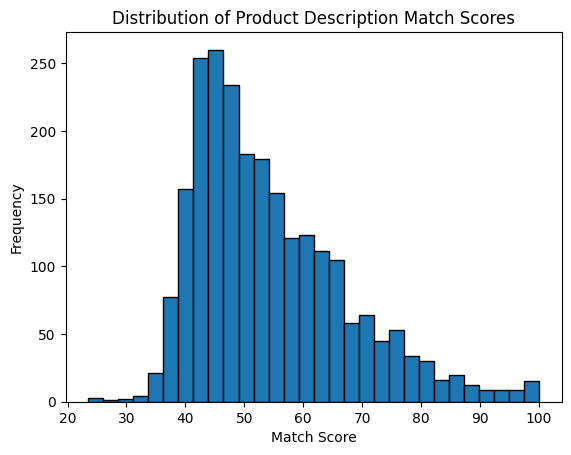

In [67]:
import matplotlib.pyplot as plt

reports['Desc. Match Score'].hist(bins=30, edgecolor='black')
plt.title('Distribution of Product Description Match Scores')
plt.xlabel('Match Score')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

#### Analyze The Rows With Similarity Greater Than 80

In [69]:
reports80 = reports[reports['Desc. Match Score']>80]

In [71]:
reports80.shape

(108, 48)

In [75]:
reports80[cols_combined].sort_values(by=['Desc. Match Score','Brand Match Score'],ascending=False).tail(58)

,Brand,Best Brand Match,Brand Match Score,Brand Best Match Meta Data Index,Product Description,Best Desc. Match,Desc. Match Score,Best Desc. Match Meta Data Index
992,Vetech,Vtech,90.909091,97370.0,Lil Critters Spin and Discover Ferris Wheel,VTech Baby Lil' Critters Spin and Discover Fer...,87.755102,487827
668,Sesame Street,Sesame Street,100.000000,3181.0,Red Elmo Plush Toy,Elmo Plush Toy,87.500000,137574
2021,Stats,Stats,100.000000,205394.0,Inflatable Basketball Hoop,Inflatable Basketball,87.500000,248700
1065,Playskool,Playskool,100.000000,2318.0,Sesame Street Big Hugs Elmo,Sesame Street Many Hugs Elmo,87.272727,121763
831,Garanimals,Garanimals,95.238095,154868.0,"Garanimals 3 in 1 stacking cups, shape sorter ...","Garanimals 3 in 1 Stacking Cups, Shape Sorter ...",87.142857,364003
40,Radio Flyer,Radio Flyer,100.000000,2067.0,Radio Flyer Scoot & Zoom,Radio Flyer 711B Scoot N Zoom,86.792453,274140
998,Thunder Tumbler,Thunder Tumbler,100.000000,116078.0,"Blue Hat Toy Cmpany Thunder Tumbler, Radio Con...",Blue Hat Thunder Tumbler Radio Control 360 Ral...,86.666667,385974
1980,Fisher Price,Fisher Price,100.000000,2450.0,Fisher Price Laugh & Learn Learning Farm P7680,Fisher-Price Laugh &amp; Learn Learning Farm,86.666667,126625
670,Munchkin,Munchkin,94.117647,3596.0,Munchkin- Float and Play Bubbles bath toys 4 set,"Munchkin Float and Play Bubbles Bath Toy, 4 Count",86.597938,389441
2163,Black & Decker,Black & Decker,100.000000,71468.0,Black & DeckerJunior Tool Belt Set,Black and Decker Jr Tool Belt Set,86.567164,604949


If we inspect with respect to brand matches and sort in ascending order with respect to brand matches: 

In [340]:
reports_brand_desc80[cols_combined].sort_values(by=['Brand Match Score']).head(20)

,Brand,Best Brand Match,Brand Match Score,Brand Best Match Meta Data Index,Product Description,Best Desc. Match,Desc. Match Score,Best Desc. Match Meta Data Index
408,Garanimals Pull Apart Sorter Ball:,Farm Animals PlaySet,51.851852,323812.0,Garanimals Pull Apart Sorter Ball:,Garanimals Pull Apart Shape Sorter,82.352941,174878
2253,1000 Piece Dogs on the Dock,Kitsch on the Rocks,56.521739,266391.0,1000 piece jig saw puzzle,100 Piece Jigsaw Puzzle,83.333333,300980
2329,"Nintendo, illumination, universal","Bendon, Illumination Entertainment",64.705882,555242.0,Super Mario Bros Movie Bowser figure,Super Mario Bros Bowser Mini Figure,81.690141,286902
1263,GLOW by Michaels,Michaels,66.666667,204717.0,Glow Bracelets,Glow Bracelets,100.000000,150116
1499,UDI R/C U16,UDI RC,70.588235,279614.0,Remote Control Helicopter,2 Channel Remote Control Helicopter,83.333333,358075
371,Oball Football,Football,72.727273,331991.0,Oball football,Oball Football,92.857143,224259
1393,Skidding,Sid Trading,73.684211,179568.0,Remote control car,Remote Control Car,88.888889,454183
1433,Fisher price/ Disney,Fisher Price inc.,75.675676,318913.0,Fisher-Price Disney Pixar Cars 2 - Bubble Mate...,Fisher-Price Disney/Pixar Cars 2 Bubble Mater,81.481481,172157
1411,DMA Inc,M Inc.,76.923077,162978.0,Remote Control Helicopter,2 Channel Remote Control Helicopter,83.333333,358075
1697,Barbie doll by Mattel,Barbie Doll Mattel Inc.,77.272727,51828.0,Barbie doll,Barbie Pool,81.818182,54571


By inspecting this list we observe that product description gives good matches compared to brand matches. There is only one different elemtn 100 piece jigsaw puzzle vs 1000 piece jigsaw puzzle.

#### Analyze The Rows With Similarity Greater Than 70 and Less Than 80

In [80]:
filter70_80 = (reports['Desc. Match Score']>70) & (reports['Desc. Match Score']<=80)
reports70 = reports[filter70_80]

In [84]:
reports70.shape

(189, 48)

In [86]:
reports70[cols_combined].sort_values(by=['Desc. Match Score','Brand Match Score'],ascending=False).head(50)

,Brand,Best Brand Match,Brand Match Score,Brand Best Match Meta Data Index,Product Description,Best Desc. Match,Desc. Match Score,Best Desc. Match Meta Data Index
457,Scentsy Buddy,Scentsy Buddy,100.000000,569130.0,Plush toy,Plush Money,80.000000,614335
1857,Glow Stick,Glow Stick,100.000000,262285.0,Glow Stick 15 bracelets with 15 connectors,50 RED Glow Stick Bracelets with Connectors,80.000000,280674
1903,Target,Target,100.000000,5600.0,Small Baby Doll Stroller,Triplet Baby Doll Stroller,80.000000,107491
1928,Parents,Parents,100.000000,4448.0,spinning top,Spinning Tops,80.000000,354205
1968,Fisher-Price,Fisher-Price,96.000000,2144.0,Ocean Wonder Soothe and Glow Seahorse(pink),Fisher-Price Ocean Wonders Soothe and Glow Sea...,80.000000,267810
757,T.D. Toys,T.L. Toys,84.210526,250243.0,Indoor Remote Control Helicopter,Copper 9098 Remote Control Helicopter,80.000000,172635
1235,Wowwee Robotics,Tosy Robotics,71.428571,311489.0,Robosapien 2,Mini Robosapien V2,80.000000,25891
1286,KOIEMAY,KOMKA,66.666667,107296.0,Magnetic blocks,BRIO Magnetic Blocks,80.000000,9133
1417,R C,RC,66.666667,75709.0,helicopter,v10 helicopter,80.000000,225624
306,NaN,None,NaN,NaN,Mickey Mouse bubble machine,Mickey Mouse Bubble Wand Set,80.000000,280314


In [92]:
reports70[cols_combined].sort_values(by=['Desc. Match Score','Brand Match Score']).tail(50)

,Brand,Best Brand Match,Brand Match Score,Brand Best Match Meta Data Index,Product Description,Best Desc. Match,Desc. Match Score,Best Desc. Match Meta Data Index
1994,Fisher Price,Fisher Price,100.000000,2450.0,Fisher Price soothe and glow seahorse,Fisher-Price Soothe and Glow Giraffe,76.712329,400047
2382,Melissa & Doug 3723,Melissa & Doug,84.848485,420.0,Melissa & Doug Farm Animals Chunky Puzzle - 8 ...,Melissa &amp; Doug Farm Wooden Chunky Puzzle (...,76.923077,37592
2421,Hasbro,Hasbro,92.307692,703.0,Barbie monopoly,Barbie Pool,76.923077,54571
1659,Lightning McQueen,Lightning McQueen,100.000000,96684.0,Pillow Pet,Pillow Pets Lion,76.923077,364359
1667,Orbeez,Orbeez,100.000000,165848.0,"Orbeez Mood Lamp,",Orbeez Mood Lamp Flame Toy,77.272727,398168
1838,Unknown,Unknown,93.333333,376.0,Doll stroller,Toy Doll Stroller,77.419355,48454
580,Leap Frog,Leap Frog,100.000000,3542.0,Plastic Toy Drum,Plastic Trumpet,77.419355,129823
1590,Dream Dazzlers,Dream Dazzlers,100.000000,111842.0,Dream Dazzlers Fun Princess Phone,Dream Dazzlers Glam Fur Phone,77.419355,341479
1640,Fisher Price,Fisher Price,100.000000,2450.0,Fisher Price Sooth and Glow Seahorse-pink,Fisher-Price Ocean Wonders Soothe and Glow Sea...,77.551020,267810
292,Radio Flyer,Radio Flyer,100.000000,2067.0,Radio Flyer 10” Classic Red Tricycle,Radio Flyer Classic Red Scooter,77.611940,4208


We observe that even between 70 and 80 there are a lot of perfect matches. We need more detailed work on this interval.

# 2. Result as a Matrix

Now we will calculate the similarity score between every element in report indices and Amazon products. 

## 1. Brand Matches

In [94]:
from rapidfuzz.process import cdist
# Call null values as unmatchable to keep column and row indices matched with data
UNMATCHABLE = '__MISSING__'
brand_queries = reports['Brand'].fillna(UNMATCHABLE).astype(str).tolist()
brand_choices = df_meta['brand'].astype(str).tolist()

# Create a similarity matrix (rows: reports, columns: df_meta)
similarity_brand_matrix = cdist(
    brand_queries,
    brand_choices,
    scorer=rf.fuzz.ratio,  
    processor=str.lower,   
    workers=24            
)

In [96]:
similarity_brand_matrix.shape

(2363, 624284)

In [98]:
sim_brand_df = pd.DataFrame(similarity_brand_matrix, index=brand_queries, columns=brand_choices)

In [100]:
sim_brand_df

,Dr. Seuss,Pathfinder Roleplaying Jon Brazer Productions,Betty Lukens,Dutch Blitz Games Co,Lee Publications,Gale Force Nine,Num Noms,UDI,Design Farm,Oxford Ort Packs,...,Disney,Barbie,Disney,jrelecs,Marvel,GEILIENERGY,Micord,WavePy,Lewo,Baby Einstein
POLKA DROP SLIME,40.000000,29.508196,21.428572,33.333332,31.250000,38.709679,25.000000,21.052631,29.629629,31.250000,...,27.272728,36.363636,27.272728,26.086956,27.272728,22.222221,18.181818,18.181818,20.000000,27.586206
Nickledodeon Slime,29.629629,25.396826,26.666666,31.578947,35.294117,42.424244,23.076923,19.047619,34.482758,29.411764,...,25.000000,16.666666,25.000000,24.000000,16.666666,34.482758,33.333332,8.333333,27.272728,25.806452
Lalaloopsy Color Me ( Squiggles N. Shapes ),23.076923,29.545454,25.454546,25.396826,23.728813,34.482758,15.686275,8.695652,25.925926,27.118645,...,16.326530,16.326530,16.326530,20.000000,16.326530,22.222221,12.244898,12.244898,8.510638,28.571428
Play Doh,11.764706,26.415094,20.000000,28.571428,33.333332,26.086956,25.000000,18.181818,10.526316,16.666666,...,14.285714,14.285714,14.285714,13.333333,14.285714,21.052631,14.285714,28.571428,33.333332,28.571428
Nickelodeon,19.047619,24.561403,33.333332,25.000000,28.571428,29.629629,20.000000,13.333333,34.782608,28.571428,...,22.222221,22.222221,22.222221,31.578947,22.222221,34.782608,44.444443,11.111111,37.500000,24.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fusion Select,27.272728,31.034483,24.000000,30.303030,34.482758,28.571428,28.571428,25.000000,33.333332,27.586206,...,31.578947,21.052631,31.578947,40.000000,21.052631,25.000000,21.052631,10.526316,23.529411,30.769230
Squishmallow,28.571428,14.035088,16.666666,25.000000,28.571428,22.222221,30.000000,26.666666,26.086956,7.142857,...,22.222221,11.111111,22.222221,10.526316,33.333332,17.391304,22.222221,11.111111,25.000000,16.000000
Big Bang,11.764706,22.641510,30.000000,28.571428,33.333332,26.086956,25.000000,18.181818,42.105263,16.666666,...,28.571428,28.571428,28.571428,0.000000,14.285714,31.578947,14.285714,14.285714,0.000000,28.571428
1. Speks Crags [REDACTED],35.294117,34.285713,16.216217,26.666666,24.390244,25.000000,12.121212,7.142857,27.777779,24.390244,...,12.903226,19.354839,12.903226,18.750000,19.354839,16.666666,19.354839,12.903226,6.896552,26.315790


## 3. Product Description Match

In [112]:
# Ensure both series are strings 
desc_queries = reports['Product Description'].astype(str).tolist()
title_choices = df_meta['title'].astype(str).tolist()

# Create a similarity matrix (rows: reports, columns: df_meta)
similarity_desc_matrix = cdist(
    desc_queries,
    title_choices,
    scorer=rf.fuzz.ratio,  
    processor=str.lower,   
    workers=24             
)

In [113]:
sim_desc_df = pd.DataFrame(similarity_desc_matrix, index=desc_queries, columns=title_choices)

In [114]:
sim_desc_df

,Dr. Suess 19163 Dr. Seuss Puzzle 3 Pack Bundle,Pathfinder: Book of Beasts - Legendary Foes,Nursery Rhymes Felt Book,Dutch Blitz Card Game,Magic Pen Painting (Marvel Super Heroes),Dungeons &amp; Dragons - &quot;Storm Kings Thunder&quot; DM Screen,NUM NOMS figures Storage Case Organizer - holds 20 figures,UDI U806 Infrared Remote Control Helicopter W/gyro - RED,Stellaluna Finger Puppet,Oxford Ort Packs Numicon Cuisenaire Rods Small Set,...,Disney/Pixar Cars Wheel Action Drivers Frank Vehicle,Barbie Office &amp; Doll,Disney Villains Cruella Rectangular Lucite Key Ring,jrelecs 2PCS 4MM Banana Plug to EC5 Male Converter 12AWG Wire Charger Adapter,Marvel Funko Pop Black Suit Spider-Man #79 (Glow in the Dark Exclusive),Geilienergy 6V 2000mAh NiMH RX Battery Packs with Hitec Connector for RC Aircrafts and Walking Robot,Micord Baby Float Toddler Swimming Inflatable Ride-ons Seat 6-24Months,"Premium Swimming Pool Float Hammock, Inflatable Swimming Pools Lounger, Water Hammock Lounge, Luxury Swimming Pool and Ocean Lilo (Pink)",Lewo Wooden Baby Toddler Toys Circle First Bead Maze for Boys Girls,Baby Einstein Take Along Tunes Musical Toy
Slime globe with colored spheres which resemble [REDACTED] cereal or [REDACTED],28.799999,32.786884,25.242718,28.000000,33.613445,31.724138,36.496349,38.518520,23.300970,35.658916,...,39.694656,23.300970,35.384617,38.461540,34.666668,36.871510,36.241611,34.418606,39.726028,29.752066
Slime kit from Nickelodeon by Cra-Z-Art,28.235294,31.707317,31.746031,26.666666,30.379747,28.571428,32.989689,35.789474,25.396826,31.460674,...,30.769230,28.571428,31.111111,32.758621,30.909090,33.093525,31.192661,24.000000,33.962265,34.567902
Lalaloopsy Color Me Doll ( Squiggles N. Shapes) of MGA Entertainment,31.578947,30.630630,23.913044,24.719101,29.629629,35.820896,34.920635,29.032259,30.434782,38.983051,...,35.000000,26.086956,35.294117,34.482758,35.971222,29.761906,34.782608,32.352940,35.555557,32.727272
Play Doh by Hasbro,18.750000,32.786884,33.333332,35.897434,27.586206,21.428572,21.052631,21.621622,19.047619,23.529411,...,22.857143,28.571428,20.289856,21.052631,24.719101,22.033897,22.727272,15.584415,28.235294,26.666666
Cra-z-art Nickelodeon slime party pack,33.333332,34.567902,29.032259,33.898304,33.333332,26.923077,27.083334,34.042553,32.258064,38.636364,...,33.333332,32.258064,31.460674,31.304348,33.027523,27.536232,35.185184,25.287355,30.476191,37.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Fusion Select roller ball candy - photos provided. CPSC urges all importers, distributers, and retailers to immediately stop importing, distributing, and selling roller ball candy type products.",23.236515,25.210085,16.438356,14.814815,22.978724,29.118774,28.458498,28.685259,18.264841,29.387754,...,26.720648,16.438356,26.829268,32.352940,28.571428,35.932205,32.452831,36.858006,32.824429,27.004219
It is a reversible stuffed animal called a flip-a-mallow,31.372549,34.343433,27.500000,31.168831,33.333332,26.229507,36.842106,33.928570,27.500000,32.075470,...,35.185184,37.500000,35.514019,33.082706,33.070866,33.333332,34.920635,31.250000,37.398373,36.734695
Bubble blaster,23.333334,28.070175,26.315790,34.285713,22.222221,20.000000,19.444445,20.000000,26.315790,18.750000,...,21.212122,26.315790,24.615385,19.780220,21.176470,15.789474,23.809525,13.333333,24.691359,25.000000
Magnetic ferrite putty stones 500+ in a tin sold in Amazon by many sellers/companies,27.692308,33.070866,22.222221,22.857143,41.935482,34.666668,33.802818,32.857143,24.074074,35.820896,...,32.352940,25.925926,29.629629,32.298138,36.129032,33.695652,36.363636,35.454544,35.761589,33.333332


#### In "Product Description" and "Title" Matching Matrix Find Elements With Similarity Scores > 80

In [134]:
import numpy as np
# Find all values greater than 80
high_similarity_scores = similarity_desc_matrix > 80

# Count the number of True values (similarity scores > 80)
count_high_similarity = np.sum(high_similarity_scores)

print(f'Number of similarity scores greater than 80 in Product Description: {count_high_similarity}')

Number of similarity scores greater than 80 in Product Description: 356


In [140]:
# Find all values greater than 80
high_similarity_scores = similarity_brand_matrix > 90

# Count the number of True values (similarity scores > 80)
count_high_similarity = np.sum(high_similarity_scores)

print(f'Number of similarity scores greater than 90 in Brand: {count_high_similarity}')

Number of similarity scores greater than 90 in Brand: 1372696


In [144]:
# Find all values greater than 70
high_similarity_scores70 = similarity_desc_matrix > 70

# Count the number of True values (i.e., similarity scores > 80)
count_high_similarity70 = np.sum(high_similarity_scores70)

print(f'Number of similarity scores greater than 70 in Product Description: {count_high_similarity70}')

Number of similarity scores greater than 70 in Product Description: 2877


Find the number of Amazon products corresponding to each incident report:

In [152]:
match_counts80 = (sim_desc_df > 80).sum(axis=1)

In [168]:
match_counts80_sorted_df = match_counts80.sort_values(ascending=False).reset_index()
match_counts80_sorted_df.columns = ['report_descr', 'match_count_above_80']

# Keep only rows with match count > 0
match_counts80_sorted_positive_df = match_counts80_sorted_df[match_counts80_sorted_df['match_count_above_80'] > 0]
match_counts80_sorted_positive_df

,report_descr,match_count_above_80
0,1000 piece jig saw puzzle,29
1,Playskool Mr. Potato Head Pirate Spud,11
2,Little Tikes Cozy Coupe,10
3,Fisher Price Laugh & Learn Learning Kitchen,7
4,Thunder Tumbler Radio Control 360 Rally Car,7
...,...,...
161,Egg Splat Ball,1
162,Latex balloons,1
163,Stuffed horse,1
164,Playhut: crawl n play,1


In [172]:
# Keep only rows with match count > 2
match_counts80_sorted_one_df = match_counts80_sorted_df[match_counts80_sorted_df['match_count_above_80'] > 2]
match_counts80_sorted_one_df

,report_descr,match_count_above_80
0,1000 piece jig saw puzzle,29
1,Playskool Mr. Potato Head Pirate Spud,11
2,Little Tikes Cozy Coupe,10
3,Fisher Price Laugh & Learn Learning Kitchen,7
4,Thunder Tumbler Radio Control 360 Rally Car,7
5,V-tech Kidizoom Digital Camera,6
6,Remote Control Helicopter,6
7,Remote Control Helicopter,6
8,Hot Wheels Track Builder System,5
9,Fisher-Price Little People Builders' Load 'n G...,5


In [180]:
match_counts70 = (sim_desc_df > 70).sum(axis=1)

match_counts70_sorted_df = match_counts70.sort_values(ascending=False).reset_index()
match_counts70_sorted_df.columns = ['report_descr', 'match_count_above_70']

# Keep only rows with match count > 2
match_counts70_sorted_one_df = match_counts70_sorted_df[match_counts70_sorted_df['match_count_above_70'] > 2]
pd.set_option('display.max_rows', 1000)
match_counts70_sorted_one_df

,report_descr,match_count_above_70
0,1000 piece jig saw puzzle,247
1,Disney Princess pogo stick.,95
2,Fisher Price Little People Builders Wagon. P8977,71
3,Fisher-Price Little People Builders' Load 'n G...,67
4,Fisher Price Laugh & Learn Learning Kitchen,51
5,Micro Cessna 781 2ch Electric RTF Remote Contr...,50
6,Remote Control Helicopter,41
7,Remote Control Helicopter,41
8,Hotwheels Sky Jump Track Set,39
9,VTech Go Go Smart Wheels Train Station,37


If we filter with brand match score >90:

Try token set ratio

In [187]:
from rapidfuzz import fuzz
# Ensure both series are strings 
desc_queries = reports['Product Description'].astype(str).tolist()
title_choices = df_meta['title'].astype(str).tolist()

# Create a similarity matrix (rows: reports, columns: df_meta)
similarity_desc_matrix2 = cdist(
    desc_queries,
    title_choices,
    scorer=fuzz.token_set_ratio,  
    processor=str.lower,   
    workers=24             
)

In [189]:
# Find all values greater than 80
high_similarity_scores2 = similarity_desc_matrix2 > 80

# Count the number of True values (similarity scores > 80)
count_high_similarity2 = np.sum(high_similarity_scores2)

print(f'Number of similarity scores greater than 80 in Product Description: {count_high_similarity2}')

Number of similarity scores greater than 80 in Product Description: 74909


Much higher number of match in Product Description!